In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, make_scorer, roc_curve

%matplotlib inline

# Churn

In [2]:
df_churn = pd.read_csv("fdb_churn_train.csv", index_col=0)
df_churn["next_3_months_spend"] = df_churn["next_3_months_spend"].fillna(0)

In [3]:
y1 = df_churn.churn
y2 = df_churn.next_3_months_spend
X = df_churn.iloc[:,:-2]

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2773 entries, 1517 to 3174
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               2773 non-null   float64
 1   first_purchase_date      2773 non-null   object 
 2   last_purchase_date       2773 non-null   object 
 3   total_purchases          2773 non-null   int64  
 4   total_purchase_amount_x  2773 non-null   float64
 5   last_3_months_spend      2773 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 151.6+ KB


In [5]:
df_churn.sum()

CustomerID                                                       4.23079e+07
first_purchase_date        2011-04-052011-03-312011-02-132011-08-192011-0...
last_purchase_date         2011-07-272011-09-232011-09-042011-08-192011-0...
total_purchases                                                        10010
total_purchase_amount_x                                          4.38073e+06
last_3_months_spend                                              1.77524e+06
next_3_months_spend                                              1.72441e+06
churn                                                                   1324
dtype: object

In [6]:
df_churn["last_purchase_date"].max()

'2011-09-30'

In [7]:
X["length"] = (pd.to_datetime(df_churn.last_purchase_date) - 
                     pd.to_datetime(df_churn.first_purchase_date)).apply(lambda x:x.days)
X["recency"] = (pd.to_datetime("2011-10-01") - 
                     pd.to_datetime(df_churn.last_purchase_date)).apply(lambda x:x.days)

In [8]:
X = X.iloc[:,3:]

In [9]:
# Split train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y1, shuffle=True, test_size=0.2, random_state=42, stratify=y1)
X_train, X_test, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42, stratify=y1)


In [10]:
def model_scores(model, X, y):
    y_hat = model.predict(X)
    print(f"Accuracy: {accuracy_score(y, y_hat).round(3)} \t Recall: {recall_score(y, y_hat).round(3)} \t Precision: {precision_score(y, y_hat).round(3)} \t F1: {f1_score(y, y_hat).round(3)}")
    return accuracy_score(y, y_hat), recall_score(y, y_hat), precision_score(y, y_hat), f1_score(y, y_hat)

In [11]:
y_train.mean()

0.47745716862037874

## Logistic Regression

In [15]:
# logister 
# class_weight
weights = {0:0.1, 1:1.0}
# lr = LogisticRegression(class_weight=weights)
lr = LogisticRegression()
lr.fit(X_train, y_train)

model_scores(lr, X_train, y_train)

Accuracy: 0.697 	 Recall: 0.731 	 Precision: 0.667 	 F1: 0.697


(0.69702434625789, 0.7308781869688386, 0.6666666666666666, 0.6972972972972973)

In [1260]:
model_scores(lr, X_test, y_test)

Accuracy: 0.64 	 Recall: 0.675 	 Precision: 0.611 	 F1: 0.642


(0.6396396396396397,
 0.6754716981132075,
 0.6109215017064846,
 0.6415770609318996)

In [1182]:
weights_list = [{0:0.01, 1:1.0}, {0:0.003, 1:1.0}, {0:0.05, 1:1.0}, {0:0.1, 1:1.0}, {0:0.15, 1:1.0}, {0:0.2, 1:1.0}]
parameters = {'class_weight': weights_list}

In [1183]:
f1_scorer = make_scorer(f1_score)
gslr = GridSearchCV(lr, 
                    parameters#,                   scoring=f1_scorer
                   )
gslr.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'class_weight': [{0: 0.01, 1: 1.0}, {0: 0.003, 1: 1.0},
                                          {0: 0.05, 1: 1.0}, {0: 0.1, 1: 1.0},
                                          {0: 0.15, 1: 1.0},
                                          {0: 0.2, 1: 1.0}]},
             pre_dispatch='2*n_jobs', refit=True, return_train_sco

In [1184]:
pd.DataFrame(gslr.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.0213432,0.0188436,0.0149413,0.0137173,0.0117781,0.0134012
std_fit_time,0.00155735,0.00180905,0.000502015,0.00067846,0.000495462,0.000769515
mean_score_time,0.00131593,0.000940943,0.000897408,0.00089674,0.000926447,0.000924826
std_score_time,0.000161867,3.90205e-05,3.89331e-05,4.08005e-05,6.4775e-05,5.76664e-05
param_class_weight,"{0: 0.01, 1: 1.0}","{0: 0.003, 1: 1.0}","{0: 0.05, 1: 1.0}","{0: 0.1, 1: 1.0}","{0: 0.15, 1: 1.0}","{0: 0.2, 1: 1.0}"
params,"{'class_weight': {0: 0.01, 1: 1.0}}","{'class_weight': {0: 0.003, 1: 1.0}}","{'class_weight': {0: 0.05, 1: 1.0}}","{'class_weight': {0: 0.1, 1: 1.0}}","{'class_weight': {0: 0.15, 1: 1.0}}","{'class_weight': {0: 0.2, 1: 1.0}}"
split0_test_score,0.47973,0.47973,0.509009,0.531532,0.54955,0.567568
split1_test_score,0.502252,0.490991,0.52027,0.540541,0.558559,0.56982
split2_test_score,0.493243,0.488739,0.509009,0.540541,0.563063,0.572072
split3_test_score,0.496614,0.492099,0.51693,0.548533,0.58465,0.602709


## random forest

In [37]:
## random forest

rf = RandomForestClassifier(criterion= 'gini', max_depth = 4, max_features = 'sqrt')

rf.fit(X_train, y_train)

model_scores(rf, X_train, y_train)

Accuracy: 0.719 	 Recall: 0.747 	 Precision: 0.69 	 F1: 0.717


(0.7186654643823264,
 0.7469310670443815,
 0.6896251089799477,
 0.7171350861287397)

In [38]:
model_scores(rf, X_test, y_test)

Accuracy: 0.652 	 Recall: 0.679 	 Precision: 0.625 	 F1: 0.651


(0.6522522522522523, 0.6792452830188679, 0.625, 0.650994575045208)

In [33]:
rf_params = {'criterion': ('gini', 'entropy'), 'max_depth': [2, 3, 4],
              'max_features': [1, 'sqrt', 'log2', None]}

In [34]:
gsrf = GridSearchCV(rf, 
                    rf_params#,scoring=f1_scorer
                   )
gsrf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='entropy', max_depth=3,
                                              max_features=1,
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              random_

In [35]:
pd.DataFrame(gsrf.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean_fit_time,0.100279,0.107545,0.112162,0.146185,0.129206,0.122467,0.136948,0.161951,0.109373,0.125505,...,0.119061,0.167453,0.112322,0.141561,0.136062,0.208767,0.121159,0.154605,0.154926,0.250788
std_fit_time,0.00870281,0.00161408,0.00560645,0.0150514,0.0182725,0.00296646,0.0220137,0.00281025,0.00297489,0.00122519,...,0.000939665,0.00224417,0.00132507,0.00356349,0.00133199,0.00131018,0.000884347,0.00166127,0.00121183,0.00126263
mean_score_time,0.00762649,0.00768642,0.0078176,0.00857091,0.00909877,0.00830774,0.00868945,0.00832725,0.00805397,0.00797596,...,0.00752525,0.00758834,0.00784297,0.00793567,0.00782409,0.00773635,0.0079103,0.00798092,0.00818114,0.00798259
std_score_time,0.000195175,0.000257806,0.000440164,0.0015206,0.00138402,0.000206613,0.00140508,0.00098667,6.39528e-05,5.61421e-05,...,0.000228169,0.000140714,0.000147738,8.85532e-05,0.000172108,0.000172212,0.000137515,0.000160817,0.000211105,0.000118969
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,...,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy
param_max_depth,2,2,2,2,3,3,3,3,4,4,...,2,2,3,3,3,3,4,4,4,4
param_max_features,1,sqrt,log2,None,1,sqrt,log2,None,1,sqrt,...,log2,None,1,sqrt,log2,None,1,sqrt,log2,None
params,"{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 2, 'max_fea...","{'criterion': 'gini', 'max_depth': 3, 'max_fea...","{'criterion': 'gini', 'max_depth': 3, 'max_fea...","{'criterion': 'gini', 'max_depth': 3, 'max_fea...","{'criterion': 'gini', 'max_depth': 3, 'max_fea...","{'criterion': 'gini', 'max_depth': 4, 'max_fea...","{'criterion': 'gini', 'max_depth': 4, 'max_fea...",...,"{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 2, 'max_...","{'criterion': 'entropy', 'max_depth': 3, 'max_...","{'criterion': 'entropy', 'max_depth': 3, 'max_...","{'criterion': 'entropy', 'max_depth': 3, 'max_...","{'criterion': 'entropy', 'max_depth': 3, 'max_...","{'criterion': 'entropy', 'max_depth': 4, 'max_...","{'criterion': 'entropy', 'max_depth': 4, 'max_...","{'criterion': 'entropy', 'max_depth': 4, 'max_...","{'criterion': 'entropy', 'max_depth': 4, 'max_..."
split0_test_score,0.677928,0.65991,0.675676,0.677928,0.682432,0.68018,0.684685,0.695946,0.68018,0.689189,...,0.68018,0.689189,0.691441,0.684685,0.693694,0.689189,0.677928,0.68018,0.684685,0.691441
split1_test_score,0.677928,0.677928,0.682432,0.655405,0.686937,0.693694,0.693694,0.689189,0.686937,0.691441,...,0.655405,0.650901,0.682432,0.691441,0.686937,0.686937,0.693694,0.695946,0.695946,0.70045


In [36]:
gsrf.best_params_

{'criterion': 'gini', 'max_depth': 4, 'max_features': 'sqrt'}

------
## GradientBoostingClassifier

In [18]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier()

def sw(weight_a, weight_b):
    sample_weights = np.zeros(len(y_train))
    sample_weights[y_train == 0] = weight_a
    sample_weights[y_train == 1] = weight_b
    return sample_weights

sample_weights = sw(0.5, 3)

gbc.fit(X_train, y_train, sample_weight = sample_weights
       )

model_scores(gbc, X_train, y_train)


Accuracy: 0.643 	 Recall: 0.998 	 Precision: 0.573 	 F1: 0.728


(0.6433724075743913,
 0.9981114258734656,
 0.5725893824485374,
 0.7277108433734939)

In [19]:
model_scores(gbc, X_test, y_test)

Accuracy: 0.589 	 Recall: 0.966 	 Precision: 0.539 	 F1: 0.692


(0.5891891891891892,
 0.9660377358490566,
 0.5389473684210526,
 0.6918918918918918)

In [127]:
sample_weights_list = [sw(0.5, 9.1), sw(0.5, 5), sw(1, 5), sw(0.2, 10)]
# gbc_params = {'sample_weight': sample_weights_list}

In [128]:
# gsgbc = GridSearchCV(gbc, 
#                     gbc_params,
#                    scoring=f1_scorer)
# gsgbc.fit(X_train, y_train)

ValueError: Invalid parameter sample_weight for estimator GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
# pd.DataFrame(gsgbc.cv_results_).T

## KNN

In [20]:
# KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=45)

knn.fit(X_train, y_train)

model_scores(knn, X_train, y_train)


Accuracy: 0.698 	 Recall: 0.693 	 Precision: 0.681 	 F1: 0.687


(0.6983769161406672,
 0.6931067044381491,
 0.6808905380333952,
 0.6869443144595226)

In [21]:
model_scores(knn, X_test, y_test)

Accuracy: 0.64 	 Recall: 0.626 	 Precision: 0.622 	 F1: 0.624


(0.6396396396396397,
 0.6264150943396226,
 0.6217228464419475,
 0.6240601503759398)

In [1267]:
knn_params = {'n_neighbors': list(range(3,50,2))}

In [1268]:
gsknn = GridSearchCV(knn, 
                    knn_params#,scoring=f1_scorer
                    )
gsknn.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=41, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [1269]:
pd.DataFrame(gsknn.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean_fit_time,0.00295391,0.00223923,0.00219564,0.00238314,0.00227828,0.00244646,0.00226021,0.00219221,0.00226245,0.0022553,...,0.00252252,0.00222368,0.0022305,0.00231695,0.00226717,0.00221033,0.00230284,0.00240064,0.00227852,0.00230374
std_fit_time,0.000496496,0.000130042,0.000138023,0.00026815,0.000127409,0.000389736,6.31018e-05,5.01837e-05,0.00011642,9.44675e-05,...,0.0004225,7.07909e-05,0.000201012,0.000103285,8.88888e-05,6.7445e-05,7.25052e-05,0.000274056,0.000106967,9.65188e-05
mean_score_time,0.0134285,0.0105559,0.011052,0.0113822,0.0112647,0.0109583,0.0115996,0.0114863,0.0115425,0.0120564,...,0.0126883,0.0125957,0.0124089,0.0135271,0.0129546,0.013153,0.012858,0.0129954,0.0134392,0.0135188
std_score_time,0.00174374,0.000295578,0.00033026,0.000289573,0.0004478,0.000189205,0.000349627,0.00028609,0.00043039,0.000318682,...,0.000645898,0.000331556,0.000380456,0.00166361,0.000252009,0.000279148,0.000172258,0.000338036,0.000362834,0.000536593
param_n_neighbors,3,5,7,9,11,13,15,17,19,21,...,31,33,35,37,39,41,43,45,47,49
params,{'n_neighbors': 3},{'n_neighbors': 5},{'n_neighbors': 7},{'n_neighbors': 9},{'n_neighbors': 11},{'n_neighbors': 13},{'n_neighbors': 15},{'n_neighbors': 17},{'n_neighbors': 19},{'n_neighbors': 21},...,{'n_neighbors': 31},{'n_neighbors': 33},{'n_neighbors': 35},{'n_neighbors': 37},{'n_neighbors': 39},{'n_neighbors': 41},{'n_neighbors': 43},{'n_neighbors': 45},{'n_neighbors': 47},{'n_neighbors': 49}
split0_test_score,0.635135,0.644144,0.662162,0.655405,0.65991,0.644144,0.668919,0.65991,0.655405,0.650901,...,0.646396,0.650901,0.655405,0.657658,0.657658,0.650901,0.648649,0.650901,0.653153,0.653153
split1_test_score,0.628378,0.617117,0.635135,0.646396,0.65991,0.644144,0.653153,0.671171,0.668919,0.668919,...,0.65991,0.65991,0.668919,0.671171,0.668919,0.668919,0.664414,0.682432,0.675676,0.673423
split2_test_score,0.619369,0.63964,0.626126,0.666667,0.662162,0.664414,0.666667,0.655405,0.666667,0.671171,...,0.675676,0.668919,0.671171,0.668919,0.668919,0.673423,0.677928,0.677928,0.671171,0.68018
split3_test_score,0.647856,0.659142,0.672686,0.668172,0.688488,0.693002,0.702032,0.702032,0.699774,0.706546,...,0.711061,0.715576,0.711061,0.711061,0.711061,0.706546,0.713318,0.702032,0.704289,0.704289


## Support Vector Machine

In [12]:
# SVM

svm = SVC(kernel='rbf'
    ,probability=True)

svm.fit(X_train, y_train)

model_scores(svm, X_train, y_train)

Accuracy: 0.662 	 Recall: 0.81 	 Precision: 0.61 	 F1: 0.696


(0.6618575293056808,
 0.8101983002832861,
 0.6098081023454158,
 0.6958637469586375)

In [13]:
model_scores(svm, X_test, y_test)

Accuracy: 0.627 	 Recall: 0.755 	 Precision: 0.585 	 F1: 0.659


(0.6270270270270271,
 0.7547169811320755,
 0.5847953216374269,
 0.6589785831960461)

In [1472]:
weights_list = ["balanced", {0:0.01, 1:1.0}, {0:0.003, 1:1.0}, {0:0.05, 1:1.0}, {0:0.1, 1:1.0}, {0:0.15, 1:1.0}, {0:0.2, 1:1.0}]

svm_params = {"kernel": ('linear', 'poly', 'rbf', 'sigmoid', 'precomputed')}

In [ ]:
gssvm = GridSearchCV(svm, 
                    svm_params#,                   scoring=f1_scorer
                    )
gssvm.fit(X_train, y_train)

In [160]:
pd.DataFrame(gssvm.cv_results_).T

,0,1,2,3,4,5,6
mean_fit_time,23.5735,22.111,22.0102,23.5942,24.6875,26.3163,26.2146
std_fit_time,0.694025,1.8366,1.67897,0.808296,0.804636,1.23976,1.90191
mean_score_time,0.0125141,0.0126651,0.0114753,0.0139561,0.0106471,0.0125728,0.0117753
std_score_time,0.00095126,0.00119365,0.00105556,0.00196089,0.000819926,0.0017456,0.00109966
param_class_weight,balanced,"{0: 0.01, 1: 1.0}","{0: 0.003, 1: 1.0}","{0: 0.05, 1: 1.0}","{0: 0.1, 1: 1.0}","{0: 0.15, 1: 1.0}","{0: 0.2, 1: 1.0}"
params,{'class_weight': 'balanced'},"{'class_weight': {0: 0.01, 1: 1.0}}","{'class_weight': {0: 0.003, 1: 1.0}}","{'class_weight': {0: 0.05, 1: 1.0}}","{'class_weight': {0: 0.1, 1: 1.0}}","{'class_weight': {0: 0.15, 1: 1.0}}","{'class_weight': {0: 0.2, 1: 1.0}}"
split0_test_score,0.0150164,0.047619,0.167401,0,0,0,0.0140845
split1_test_score,0,0.0213523,0.144928,0.00165098,0,0,0
split2_test_score,0,0.136646,0.22619,0.0148883,0,0.0280702,0.0210526
split3_test_score,0.0094231,0.0509554,0.150602,0,0,0.177936,0.107198


In [22]:
lr_fpr, lr_tpr, lr_thresh = roc_curve(y_test, lr.predict_proba(X_test)[:, 1])

knn_fpr, knn_tpr, knn_thresh = roc_curve(y_test, knn.predict_proba(X_test)[:, 1])

rf_fpr, rf_tpr, rf_thresh = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])

gbc_fpr, gbc_tpr, gbc_thresh = roc_curve(y_test, gbc.predict_proba(X_test)[:, 1])

svm_fpr, svm_tpr, svm_thresh = roc_curve(y_test, svm.predict_proba(X_test)[:, 1])


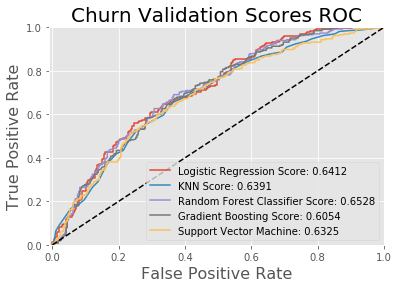

In [23]:

plt.plot(lr_fpr, lr_tpr, label='Logistic Regression Score: {:.4f}'.format(roc_auc_score(y_test, lr.predict(X_test))))

plt.plot(knn_fpr, knn_tpr, label='KNN Score: {:.4f}'.format(roc_auc_score(y_test, knn.predict(X_test))))

plt.plot(rf_fpr, rf_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_test, rf.predict(X_test))))

plt.plot(gbc_fpr, gbc_tpr, label='Gradient Boosting Score: {:.4f}'.format(roc_auc_score(y_test, gbc.predict(X_test))))

plt.plot(svm_fpr, svm_tpr, label='Support Vector Machine: {:.4f}'.format(roc_auc_score(y_test, svm.predict(X_test))))

plt.plot([0, 1], [0, 1], 'k--')
plt.axis([-0.01, 1, 0, 1])
plt.title('Churn Validation Scores ROC', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc='lower right')
plt.show()

## Testing

In [24]:
df_train = pd.concat([X_train, y_train,y_train2], axis=1)
train_for_predict = df_train.groupby("churn").last_3_months_spend.mean()


In [25]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2218 entries, 2129 to 3234
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   total_purchases          2218 non-null   int64  
 1   total_purchase_amount_x  2218 non-null   float64
 2   last_3_months_spend      2218 non-null   float64
 3   length                   2218 non-null   int64  
 4   recency                  2218 non-null   int64  
 5   churn                    2218 non-null   int64  
 6   next_3_months_spend      2218 non-null   float64
dtypes: float64(3), int64(4)
memory usage: 138.6 KB


In [1413]:
test_pre = pd.Series(rf.predict(X_test)).value_counts().sort_index().dot(train_for_predict)

In [39]:
test_pre = ((1- rf.predict(X_test)) * X_test["last_3_months_spend"]).sum()

In [40]:
test_act = y_test2.sum(); test_act

335471.84

In [41]:
test_pre/test_act - 1

-0.026178796408068195

In [84]:
predict = (1- rf.predict(X_test)) * X_test["last_3_months_spend"]
RMSE = (((predict - y_test2)**2).sum() / y_test2.shape[0]) **0.5; RMSE

1651.1404965055453

_______
# RFM
## RFM 3X3X3

In [25]:
df_RFM = pd.read_csv("fdb_RFM2_train.csv", index_col=0)

In [26]:
df_RFM["RFM"] = df_RFM["RFM"].fillna("1-1-1")
df_RFM["next_3_months_spend"] = df_RFM["next_3_months_spend"].fillna(0)

In [27]:
df_RFM.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302261 entries, 0 to 302260
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       302261 non-null  int64  
 1   first_purchase_date      302261 non-null  object 
 2   last_purchase_date       302261 non-null  object 
 3   total_purchases          302261 non-null  int64  
 4   total_purchase_quantity  302261 non-null  int64  
 5   total_purchase_amount    302261 non-null  float64
 6   last_3_months_spend      302261 non-null  float64
 7   RFM                      302261 non-null  object 
 8   next_3_months_spend      302261 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 23.1+ MB


In [28]:
y1 = df_RFM.RFM
y2 = df_RFM.next_3_months_spend
X = df_RFM.iloc[:,:-3]

In [34]:
X.head()

,total_purchases,total_purchase_quantity,total_purchase_amount,length,recency
0,52,284,976.58,267,2
1,49,837,2462.90,262,6
2,27,252,594.15,216,58
3,163,2036,4997.94,272,3
4,46,375,1510.74,266,4


In [30]:
X["length"] = (pd.to_datetime(df_RFM.last_purchase_date) - 
                     pd.to_datetime(df_RFM.first_purchase_date)).apply(lambda x:x.days)
X["recency"] = (pd.to_datetime("2012-12-02") - 
                     pd.to_datetime(df_RFM.last_purchase_date)).apply(lambda x:x.days)
X = X.iloc[:,3:]

In [31]:
# Split train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y1, shuffle=True, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42)

In [32]:
# KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=20)

knn.fit(X_train, y_train)

# model_scores(knn, X_train, y_train)

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print(accuracy) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 


0.2822027029262402


In [33]:
accuracy ** (1/27)

0.9542241718795398

In [16]:
knn.predict(X_train)

array(['3-3-3', '2-2-1', '2-2-3', ..., '3-3-3', '3-3-3', '2-2-2'],
      dtype=object)

In [168]:
### Support Vector Machine

svm_model_linear = LinearSVC().fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test) 
  
# model accuracy for X_test   
accuracy = svm_model_linear.score(X_test, y_test) 
print(accuracy) 
  
# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 

/home/vince/anaconda3/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [170]:
print(accuracy) 
cm

0.084677352654128


array([[3126, 2021,    0, ...,    0,    0,    0],
       [ 278, 1569,    0, ...,    0,    0,    0],
       [  44,  681,    0, ...,    0,    0,    0],
       ...,
       [  36, 1478,    0, ...,    0,    0,    0],
       [  23, 3977,    0, ...,    0,    0,    0],
       [  73,   95,    0, ...,    0,    0,    0]])

In [ ]:
## random forest

rf = RandomForestClassifier(class_weight='balanced')

rf.fit(X_train, y_train)

model_scores(rf, X_train, y_train)

In [75]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241808 entries, 61015 to 121958
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   total_purchases          241808 non-null  int64  
 1   total_purchase_quantity  241808 non-null  int64  
 2   total_purchase_amount    241808 non-null  float64
 3   length                   241808 non-null  int64  
 4   recency                  241808 non-null  int64  
 5   RFM                      241808 non-null  object 
 6   next_3_months_spend      241808 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 24.8+ MB


In [64]:
df_train = pd.concat([X_train, y_train,y_train2], axis=1)
train_for_predict = df_train.groupby("RFM").next_3_months_spend.mean()
train_for_predict

RFM
1-1-1     255.723603
1-1-2     767.556463
1-1-3    1475.471996
1-2-1     370.337750
1-2-2     811.361456
1-2-3    1584.313918
1-3-1     406.473289
1-3-2     834.411394
1-3-3    1910.695518
2-1-1     304.239549
2-1-2     781.819555
2-1-3    1490.470437
2-2-1     380.034984
2-2-2     821.154755
2-2-3    1633.503707
2-3-1     416.109648
2-3-2     847.408778
2-3-3    1841.652907
3-1-1     294.939754
3-1-2     779.523881
3-1-3    1462.256530
3-2-1     376.830826
3-2-2     816.724046
3-2-3    1622.465071
3-3-1   -5976.501411
3-3-2     850.213548
3-3-3    3248.858662
Name: next_3_months_spend, dtype: float64

In [49]:
y_test3 = pd.concat([y_test,y_test2], axis=1)
test_act = y_test3.groupby("RFM").sum().sum()

In [73]:
test_pre = pd.Series(knn_predictions).value_counts().sort_index().dot(train_for_predict)

In [63]:
test_act = y_test2.sum(); test_act

81041777.89000002

In [74]:
test_pre/test_act - 1

-0.2028660141184292

## RFM2X2X2

In [192]:
df_RFM = pd.read_csv("fdb_RFM3_train.csv", index_col=0)

In [86]:
df_RFM["RFM"] = df_RFM["RFM"].fillna("1-1-1")
df_RFM["next_3_months_spend"] = df_RFM["next_3_months_spend"].fillna(0)

In [87]:
df_RFM["RFM"].value_counts()/df_RFM["RFM"].count()

1-1-1    0.547782
1-1-2    0.224306
2-2-2    0.078976
1-2-2    0.053732
2-1-2    0.047602
2-1-1    0.017670
1-2-1    0.016228
2-2-1    0.013704
Name: RFM, dtype: float64

In [193]:
y1 = df_RFM.RFM
y2 = df_RFM.next_3_months_spend
X = df_RFM.iloc[:,:-2]

In [89]:
X["length"] = (pd.to_datetime(df_RFM.last_purchase_date) - 
                     pd.to_datetime(df_RFM.first_purchase_date)).apply(lambda x:x.days)
X["recency"] = (pd.to_datetime("2011-10-01") - 
                     pd.to_datetime(df_RFM.last_purchase_date)).apply(lambda x:x.days)
X = X.iloc[:,3:]

In [194]:
# X_train, y_train, X_test, y_test = train_test_split(X, y1, random_state=42, stratefy)""
X_train, X_test, y_train, y_test = train_test_split(X, y1, shuffle=True, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42)

In [1323]:
# KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=41)

knn.fit(X_train, y_train)

# model_scores(knn, X_train, y_train)

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print(accuracy) 
  
# creating a confusion matrix 
knn_predictions = knn.predict(X_test)  
cm = confusion_matrix(y_test, knn_predictions) 

0.5855855855855856


In [1321]:
knn_params = {'n_neighbors': list(range(3,50,2))}
gsknn = GridSearchCV(knn, 
                    knn_params)
gsknn.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=35, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23,
                                         25, 27, 29, 31, 33, 35, 37, 39, 41, 43,
                                         45, 47, 49]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [1322]:
pd.DataFrame(gsknn.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
mean_fit_time,0.00365553,0.00376887,0.00328102,0.003195,0.0030601,0.00333529,0.00359793,0.0030066,0.00316086,0.00318012,...,0.00312052,0.00307908,0.00317192,0.0030736,0.00301619,0.00323739,0.00325041,0.00311894,0.00309911,0.00309668
std_fit_time,0.000419741,0.000941901,0.00030757,0.000299377,0.000130784,0.000117424,0.00102857,0.000136957,0.000219671,0.000178661,...,0.000248952,0.00010497,8.26353e-05,5.49565e-05,7.86046e-05,0.00045274,0.000317031,0.000144018,0.000250905,0.000224166
mean_score_time,0.0132999,0.0114943,0.0110285,0.0116169,0.0120514,0.0133659,0.0126091,0.0118086,0.0121057,0.0123737,...,0.0129084,0.0129228,0.0140081,0.0132026,0.013529,0.013174,0.0134081,0.0134915,0.0137475,0.0138155
std_score_time,0.00155707,0.000400701,0.000203332,0.000310362,0.000739841,0.000765965,0.000947028,0.000472515,0.000542082,0.000501283,...,0.000297164,0.00049489,0.00082914,0.000339626,0.000633333,0.000383672,0.000525647,0.000403557,0.000392289,0.000325261
param_n_neighbors,3,5,7,9,11,13,15,17,19,21,...,31,33,35,37,39,41,43,45,47,49
params,{'n_neighbors': 3},{'n_neighbors': 5},{'n_neighbors': 7},{'n_neighbors': 9},{'n_neighbors': 11},{'n_neighbors': 13},{'n_neighbors': 15},{'n_neighbors': 17},{'n_neighbors': 19},{'n_neighbors': 21},...,{'n_neighbors': 31},{'n_neighbors': 33},{'n_neighbors': 35},{'n_neighbors': 37},{'n_neighbors': 39},{'n_neighbors': 41},{'n_neighbors': 43},{'n_neighbors': 45},{'n_neighbors': 47},{'n_neighbors': 49}
split0_test_score,0.504505,0.54955,0.56982,0.56982,0.578829,0.592342,0.576577,0.581081,0.56982,0.585586,...,0.585586,0.585586,0.583333,0.592342,0.587838,0.587838,0.587838,0.59009,0.594595,0.59009
split1_test_score,0.540541,0.504505,0.536036,0.558559,0.556306,0.560811,0.556306,0.572072,0.581081,0.574324,...,0.574324,0.563063,0.581081,0.576577,0.581081,0.583333,0.581081,0.578829,0.587838,0.59009
split2_test_score,0.513514,0.531532,0.536036,0.556306,0.572072,0.556306,0.563063,0.563063,0.565315,0.565315,...,0.558559,0.565315,0.556306,0.554054,0.556306,0.560811,0.558559,0.54955,0.54955,0.556306
split3_test_score,0.525959,0.514673,0.532731,0.546275,0.555305,0.544018,0.546275,0.546275,0.557562,0.555305,...,0.566591,0.562077,0.564334,0.566591,0.562077,0.562077,0.555305,0.555305,0.557562,0.555305


In [1327]:
## random forest

rf = RandomForestClassifier(class_weight = 'balanced',
                             criterion = 'entropy',
                             max_depth = 40,
                             max_features = 'log2')

rf.fit(X_train, y_train)

accuracy = rf.score(X_test, y_test) 
print(accuracy) 

# model_scores(rf, X_train, y_train)

0.5837837837837838


In [1324]:
rf_params = {"class_weight" :['balanced'],'criterion': ('gini', 'entropy'), 'max_depth': [25,40,80],
              'max_features': [1, 'sqrt', 'log2']}

In [1325]:
gsrf = GridSearchCV(rf, 
                    rf_params)
gsrf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='entropy', max_depth=25,
                                              max_features='log2',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                         

In [1326]:
pd.DataFrame(gsrf.cv_results_).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
mean_fit_time,0.20418,0.265069,0.261312,0.199941,0.258561,0.25946,0.199466,0.260744,0.258087,0.407713,0.575406,0.572094,0.404636,0.574572,0.568753,0.402637,0.587956,0.626952
std_fit_time,0.00927923,0.00739025,0.0027195,0.0013928,0.0014718,0.00282682,0.00179886,0.00361363,0.00115296,0.0179795,0.0120586,0.0130625,0.0151294,0.0158014,0.0118793,0.0134654,0.00892602,0.0438098
mean_score_time,0.0151642,0.0150477,0.0147654,0.0147791,0.0149771,0.0145866,0.0150001,0.014455,0.0148261,0.0150587,0.0142219,0.0143792,0.0147377,0.0142142,0.0146426,0.0144598,0.0143979,0.0157276
std_score_time,0.000928516,0.000686082,0.000342848,0.000312513,0.000891939,0.00054085,0.000481043,0.000459589,0.000658747,0.000355844,0.000249608,0.000346961,0.000469235,0.000348905,0.000394852,0.000526946,0.000936534,0.00207682
param_class_weight,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced,balanced
param_criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy,entropy
param_max_depth,25,25,25,40,40,40,80,80,80,25,25,25,40,40,40,80,80,80
param_max_features,1,sqrt,log2,1,sqrt,log2,1,sqrt,log2,1,sqrt,log2,1,sqrt,log2,1,sqrt,log2
params,"{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'gin...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent...","{'class_weight': 'balanced', 'criterion': 'ent..."
split0_test_score,0.56982,0.574324,0.565315,0.56982,0.565315,0.563063,0.563063,0.578829,0.563063,0.54955,0.572072,0.565315,0.567568,0.567568,0.576577,0.563063,0.560811,0.565315


In [1308]:
gsrf.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 40,
 'max_features': 1}

In [91]:
# GradientBoostingClassifier
gbc = GradientBoostingClassifier(learning_rate=0.05)

gbc.fit(X_train, y_train)

accuracy = gbc.score(X_test, y_test) 
print(accuracy) 


0.5981981981981982


In [92]:
gbc_predictions = gbc.predict(X_test)  
cm = confusion_matrix(y_test, gbc_predictions) 

## multilabel

In [1087]:
df_RFM = pd.read_csv("fdb_RFM3_train.csv", index_col=0)
df_RFM["RFM"] = df_RFM["RFM"].fillna("1-1-1")
df_RFM["next_3_months_spend"] = df_RFM["next_3_months_spend"].fillna(0)
y1 = df_RFM.RFM
y2 = df_RFM.next_3_months_spend
X = df_RFM.iloc[:,:-3]

In [1088]:
X["length"] = (pd.to_datetime(df_RFM.last_purchase_date) - 
                     pd.to_datetime(df_RFM.first_purchase_date)).apply(lambda x:x.days)
X["recency"] = (pd.to_datetime("2012-12-02") - 
                     pd.to_datetime(df_RFM.last_purchase_date)).apply(lambda x:x.days)
X = X.iloc[:,3:]

In [1089]:
R = df_RFM["RFM"].apply(lambda x:int(x[0])-1)
F = df_RFM["RFM"].apply(lambda x:int(x[2])-1)
M = df_RFM["RFM"].apply(lambda x:int(x[4])-1)
y1_1 = pd.concat([R,F,M], axis=1)
y1_1.columns =["R","F","M"]

In [1090]:
X_train, X_test, y_train, y_test = train_test_split(X, y1_1, shuffle=True, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42)

In [1091]:
## random forest

rf = RandomForestClassifier(class_weight = 'balanced',
                             criterion = 'gini',
                             max_depth = 25,
                             max_features = 1)

rf.fit(X_train, y_train)

accuracy = rf.score(X_test, y_test) 
print(accuracy) 

0.45045045045045046


In [1092]:
# KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=19)

knn.fit(X_train, y_train)

# model_scores(knn, X_train, y_train)

# accuracy on X_test 
accuracy = knn.score(X_test, y_test) 
print(accuracy) 

0.5801801801801801


## testing

In [1338]:
df_train = pd.concat([X_train, y_train,y_train2], axis=1)
train_for_predict = df_train.groupby("RFM").last_3_months_spend.mean()


RFM
1-1-1     225.234616
1-1-2     594.090063
1-2-1     489.345526
1-2-2    1761.164390
2-1-1     216.483111
2-1-2     521.661927
2-2-1     775.091071
2-2-2    2991.919118
Name: last_3_months_spend, dtype: float64

In [94]:
X_test["predict"] = gbc_predictions

In [1339]:
tempdf = pd.DataFrame(train_for_predict)

In [1340]:
tempdf["predict_counts"] = pd.Series(gbc_predictions).value_counts()

In [1341]:
tempdf.fillna(0, inplace=True)

In [1343]:
y_test3 = pd.concat([y_test,y_test2], axis=1)
test_act = y_test3.groupby("RFM").sum().sum()
test_pre = tempdf.last_3_months_spend.dot(tempdf.predict_counts)
# test_pre = pd.Series(gbc_predictions).value_counts().sort_index().dot(train_for_predict)
test_act = y_test2.sum()

In [1344]:
test_act

333217.85

In [1345]:
test_pre/test_act - 1

-0.23668880116504698

In [ ]:
predict = (1- rf.predict(X_test)) * X_test["last_3_months_spend"]
RMSE = (((predict - y_test2)**2).sum() / y_test2.shape[0]) **0.5; RMSE

# LTV

In [204]:
df_RFM = pd.read_csv("fdb_RFM3_train.csv", index_col=0);df_RFM

,CustomerID,first_purchase_date,last_purchase_date,total_purchases,total_purchase_amount_x,last_3_months_spend,RFM,next_3_months_spend
1517,16696.0,2011-04-05,2011-07-27,4,657.90,99.00,1-1-1,0.00
3182,12909.0,2011-03-31,2011-09-23,6,1807.51,321.59,1-1-2,321.32
1580,17050.0,2011-02-13,2011-09-04,6,3228.84,568.25,1-1-1,0.00
2921,12991.0,2011-08-19,2011-08-19,1,303.56,303.56,1-1-2,200.20
2832,13562.0,2011-04-08,2011-09-19,3,1799.33,1196.06,1-1-1,0.00
...,...,...,...,...,...,...,...,...
1095,17007.0,2011-05-09,2011-07-07,3,368.32,112.71,1-1-2,314.49
1130,12790.0,2011-05-31,2011-05-31,1,324.92,0.00,1-1-1,0.00
1294,16471.0,2011-03-10,2011-03-10,1,223.95,0.00,1-1-1,0.00
860,18213.0,2011-04-17,2011-04-17,1,232.48,0.00,1-1-1,0.00


In [205]:
y1 = df_RFM.RFM
y2 = df_RFM.next_3_months_spend
X = df_RFM.iloc[:,:-2]

In [206]:
# X_train, y_train, X_test, y_test = train_test_split(X, y1, random_state=42, stratefy)""
X_train, X_test, y_train, y_test = train_test_split(X, y1, shuffle=True, test_size=0.2, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, shuffle=True, test_size=0.2, random_state=42)

In [235]:
df_RFM = X_test

In [236]:
df_RFM["T"] = (pd.to_datetime("2011-10-01") - pd.to_datetime(df_RFM["first_purchase_date"]) ).apply(lambda x:x.days)

In [237]:
df_RFM["recency"] = (pd.to_datetime(df_RFM["last_purchase_date"])  
                     - pd.to_datetime(df_RFM["first_purchase_date"])).apply(lambda x:x.days)

In [238]:
df_RFM["frequency"] = (df_RFM["total_purchases"] - 1)

In [239]:
data = df_RFM[["frequency", "recency", "T"]]

In [240]:
data

,frequency,recency,T
1260,8,175,214
1469,3,98,104
3168,7,241,270
1983,0,0,108
2499,2,96,118
...,...,...,...
1873,0,0,30
1304,1,4,225
541,0,0,80
1857,1,88,197


In [241]:
g1 = data.groupby('frequency')

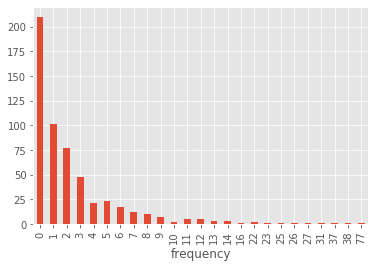

In [242]:
g1['frequency'].count().plot(kind="bar")

In [243]:
g2 = data.groupby('T')

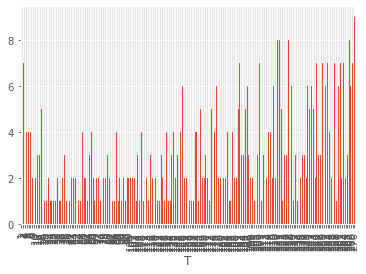

In [244]:
g2['T'].count().plot(kind="bar")

In [162]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])


bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.828311,0.035041,0.759630,0.896992
alpha,54.392343,2.780300,48.942955,59.841732
a,0.025752,0.011496,0.003220,0.048285
b,0.459774,0.231421,0.006190,0.913359


In [53]:
from lifetimes.fitters.beta_geo_beta_binom_fitter import BetaGeoBetaBinomFitter

bgf = BetaGeoBetaBinomFitter(penalizer_coef=0.03)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoBetaBinomFitter: fitted with 694 subjects, alpha: 0.20, beta: 1.82, delta: 0.70, gamma: 0.06>

In [54]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
alpha,0.203387,0.011816,0.180227,0.226547
beta,1.819381,0.109611,1.604543,2.034220
gamma,0.058370,0.007606,0.043463,0.073278
delta,0.697483,0.104078,0.493489,0.901476


In [245]:
from lifetimes.fitters.pareto_nbd_fitter import ParetoNBDFitter

In [246]:
bgf = ParetoNBDFitter(penalizer_coef=0.01)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.ParetoNBDFitter: fitted with 555 subjects, alpha: 53.79, beta: 6.56, r: 0.85, s: 0.02>

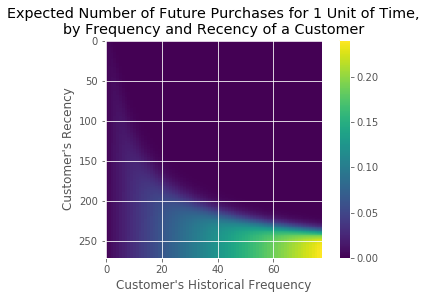

In [247]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

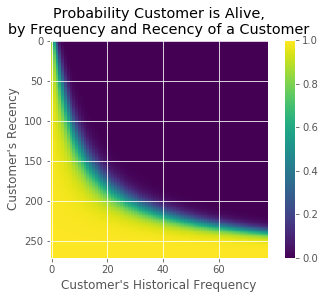

In [248]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [249]:
t = 91
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
1985,27,264,270,7.796925
2561,31,248,249,9.538105
3051,37,241,263,10.735944
2326,38,266,269,10.914109
3421,77,267,270,21.802875


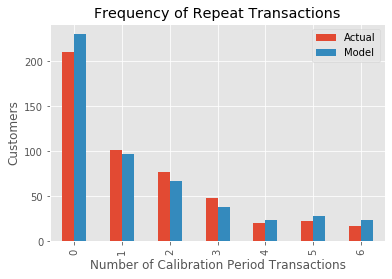

In [250]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [ ]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(transaction_data, 'id', 'date',
                                        calibration_period_end='2014-09-01',
                                        observation_period_end='2014-12-31' )
print(summary_cal_holdout.head())

In [171]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(data['frequency'], data['recency'], data['T'])
plot_calibration_purchases_vs_holdout_purchases(bgf, data)

KeyError: 'duration_holdout'

## Gamma-Gamma

In [251]:
data2 = df_RFM[["frequency", "recency", "T", "total_purchase_amount_x"]]
data2["monetary_value"] = data2["total_purchase_amount_x"] / (1 + data2["frequency"])

In [252]:
data2 = data2[["frequency", "recency", "T", "monetary_value"]]
data2["monetary_value"] = data2["monetary_value"].apply(lambda x:0.01 if x<=0 else x)

In [253]:
data2.corr()

,frequency,recency,T,monetary_value
frequency,1.000000,0.572464,0.350017,0.106046
recency,0.572464,1.000000,0.608634,0.116736
T,0.350017,0.608634,1.000000,0.004485
monetary_value,0.106046,0.116736,0.004485,1.000000


In [254]:
(data2["monetary_value"] <=0).sum()

0

In [255]:
(data2['frequency']==0).sum()

210

In [256]:
from lifetimes import GammaGammaFitter

returning_customers_summary = data2[data2['frequency']>0]

ggf = GammaGammaFitter(penalizer_coef = 0.03)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 345 subjects, p: 2.05, q: 0.25, v: 1.95>


In [257]:
returning_customers_summary["predict"] = ggf.conditional_expected_average_profit(
                                                        returning_customers_summary['frequency'],
                                                        returning_customers_summary['monetary_value']
                                                    )

In [258]:
data2['predicted_purchases'] = data['predicted_purchases']

In [259]:
data2["predict"] = returning_customers_summary["predict"]

In [260]:
data2["predict"][data2["frequency"] == 0] = data2[data2["frequency"] == 0]["monetary_value"]

In [261]:
data2.head(8)

,frequency,recency,T,monetary_value,predicted_purchases,predict
1260,8,175,214,829.873333,2.967992,870.066793
1469,3,98,104,157.132500,2.199977,179.795742
3168,7,241,270,195.882500,2.190657,207.024152
1983,0,0,108,143.300000,0.423400,143.300000
2499,2,96,118,908.193333,1.490668,1113.717380
128,11,252,258,417.238333,3.444329,431.835773
287,0,0,2,283.550000,1.324510,283.550000
2040,2,83,215,70.766667,0.904953,87.879729


In [262]:
sales_predict = data2["predict"] * data2["predicted_purchases"]

In [263]:
# sales_actual = df_RFM["next_3_months_spend"][returning_customers_summary.index].sum()
sales_actual2 = y_test2

In [264]:
RMSE = (((sales_predict - sales_actual2)**2).sum() / sales_actual2.shape[0])**0.5; RMSE

1190.8937733285234

In [1069]:
df_RFM.first_purchase_date.max()

'2011-08-31'

In [248]:
from lifetimes.datasets import load_transaction_data
from lifetimes.utils import summary_data_from_transaction_data

transaction_data = load_transaction_data()
print(transaction_data.head())
"""
                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2
"""

summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2014-12-31')

print(summary.head())
"""
frequency  recency      T
id
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0
"""

bgf.fit(summary['frequency'], summary['recency'], summary['T'])

                  date  id
0  2014-03-08 00:00:00   0
1  2014-05-21 00:00:00   1
2  2014-03-14 00:00:00   2
3  2014-04-09 00:00:00   2
4  2014-05-21 00:00:00   2
    frequency  recency      T
id                           
0         0.0      0.0  298.0
1         0.0      0.0  224.0
2         6.0    142.0  292.0
3         0.0      0.0  147.0
4         2.0      9.0  183.0


<lifetimes.BetaGeoFitter: fitted with 5000 subjects, a: 0.37, alpha: 1.79, b: 0.36, r: 0.16>

In [250]:
transaction_data[transaction_data["id"] == 2]

,date,id
2,2014-03-14 00:00:00,2
3,2014-04-09 00:00:00,2
4,2014-05-21 00:00:00,2
5,2014-06-08 00:00:00,2
6,2014-06-30 00:00:00,2
7,2014-07-31 00:00:00,2
8,2014-08-03 00:00:00,2


In [252]:
summary.iloc[2,:]

frequency      6.0
recency      142.0
T            292.0
Name: 2, dtype: float64

In [254]:
pd.to_datetime("2014-12-31") - pd.to_datetime("2014-03-14")

Timedelta('292 days 00:00:00')

In [255]:
pd.to_datetime("2014-08-03") - pd.to_datetime("2014-03-14")

Timedelta('142 days 00:00:00')

In [258]:
pd.to_datetime(df_RFM["last_purchase_date"]).max()

Timestamp('2012-11-30 00:00:00')